# SPI1 SNP scoring run #1 Sep 14 2018

- examine the bQTL SNPs from bQTL paper for SPI1 (mmc2.xlsx, SPI1 tab)
- take first 10k entries of smallest pvals
- plot bQTL SNP distance from nearest modisco seqlets supporting a pattern vs -log10(pval)

In [1]:
from __future__ import print_function, division

import logging
import sys
import os
#import matplotlib as mpl
#mpl.use('Agg')

import numpy as np
import modisco
import theano
import sys
import argparse
TFNET_ROOT = os.getenv('TFNET_ROOT', '/home/ktian/kundajelab/tfnet/')
sys.path.append(TFNET_ROOT + "/scripts")
    
#modisco_dir = "/home/ktian/kundajelab/tfnet/results/nandi/SPI1/SPI1_GM12878_refine_18_09_04/"
#modisco_dir = "/Users/kat/kundajelab/tfnet/results/nandi/SPI1/SPI1_GM12878_18_08_25/"
#os.chdir(modisco_dir)
tf = 'SPI1'

logging.basicConfig(
        format='%(asctime)s %(levelname)-5s %(message)s',
        level=logging.INFO,
        datefmt='%Y-%m-%d %H:%M:%S')

logging.info(" ".join(sys.argv))


logging.debug("Theano version:" + str(theano.__version__))
logging.debug(sys.version)


# ### Functions for one-hot encoding sequences

import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1):
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

from merge_overlaps import MergeOverlaps
from merge_overlaps import merge_overlaps

'''
def parse_args(args = None):
    parser = argparse.ArgumentParser('run_tfmodisco.py',
                                     description='run tfmodisco',
                                     formatter_class=argparse.RawTextHelpFormatter)
    parser.add_argument('--scores', type=str, help="prefix for the hypothetical score files")
    parser.add_argument('--fasta', type=str, help="fasta input")
    parser.add_argument('--tsv', type=str, help="tsv input")
    parser.add_argument('--start-task', type=int, default=0, help="start tast")
    parser.add_argument('--end-task', type=int, default=5, help="end task")
    parser.add_argument('--fdr', type=float, default=0.01, help="target FDR")
    args = parser.parse_args(args)
    return args

args = parse_args()

score_prefix = args.scores
input_name   = args.fasta
input_tsv    = args.tsv
start_task   = args.start_task
end_task     = args.end_task
target_fdr   = args.fdr
'''


#convert the motifs to log-odds space
def log_odds_space(pwm, background,pseudocount):
    new_pwm = []
    for pos_values in np.transpose(pwm,(1,0)):
        if sum(pos_values)==0:
            new_pwm.append(pos_values)
        else:
            pos_values = pos_values+pseudocount/(1+pseudocount*4)
            new_pwm.append(np.log(pos_values) - np.log(background))
    return np.array(new_pwm).transpose(1,0)

score_prefix = "../scores/hyp_scores_task_"
input_name   = "../interpret.fa"
input_tsv    = "../interpret.tsv"

start_task = 0
end_task   = 1

logging.debug("method file prefix is %s, input seq file is %s, input tsv is %s, start_task is %d end_task is %d",
              score_prefix, input_name, input_tsv, start_task, end_task)

#https://www.biostars.org/p/710/
from itertools import groupby
def fasta_iter(fasta_name):
    """
        given a fasta file, yield tuples of (header, sequence)
    """
    fh = open(fasta_name) # file handle
    # ditch the boolean (x[0]) and just keep the header or sequence since they alternate
    fa_iter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in fa_iter:
        header = header.next()[1:].strip() # drop the ">" from the header
        seq = "".join(s.strip() for s in fa_iter.next()) # join all sequence lines to one
        yield header, seq

fasta_sequences = []
fasta = fasta_iter(input_name)

for header, seq in fasta:
    fasta_sequences.append(seq)
logging.debug("lenth of sequences = %d", len(fasta_sequences))

#onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]
#logging.debug("shape of onehot" + str(onehot_data[0].shape))

# ## Prepare the data for input into TF-MoDISCo
#
# You need a numpy array of importance scores and hypothetical importance scores for every task.

from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

# locations of deeplift scores
scores_loc = []
task_names = []
for i in range(start_task , end_task):
    loc_i = score_prefix + str(i) + ".npy"
    scores_loc.append(loc_i)
    task_names.append("task" + str(i))


# scores & their one-hot encodings
merged_seq_list        = []
merged_onehot_list     = []
merged_tsv_list        = []
num_tasks = end_task - start_task
for t in range(num_tasks):
    merged_hyp_scores_list     = []
    merged_contrib_scores_list = []
    task = task_names[t]
    hyp_scores_all = np.load(scores_loc[t])
    merge_overlaps(input_tsv, hyp_scores_all, merged_hyp_scores_list, fasta_sequences,
                   merged_seq_list = merged_seq_list if t==0 else None,
                   merged_tsv_list = merged_tsv_list if t==0 else None                   )

    for i in range(len(merged_hyp_scores_list)):
        onehot_seq = one_hot_encode_along_channel_axis(merged_seq_list[i])
        contrib_scores = merged_hyp_scores_list[i] * onehot_seq
        merged_contrib_scores_list.append(contrib_scores)
        if t == 0:
            merged_onehot_list.append(onehot_seq)

    task_to_hyp_scores[task] = merged_hyp_scores_list
    task_to_scores[task]     = merged_contrib_scores_list

    if t == 0:
        logging.debug("shape of hyp_score " + str(task_to_hyp_scores[task][0].shape))
        logging.debug("shape of score " + str(task_to_scores[task][0].shape))

Using cuDNN version 7001 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:08:00.0)
2018-09-15 14:43:56 INFO  /home/ktian/anaconda3/envs/modisco_dev/lib/python2.7/site-packages/ipykernel_launcher.py -f /run/user/131/jupyter/kernel-362965a9-69e8-40a1-be9a-659819df846d.json


In [2]:
#save the scores and tsv
'''
np.savez("merged_scores.npz", *merged_hyp_scores_list)
with open("merged.tsv", 'w') as fh:
    for tsv in merged_tsv_list:
        fields = [str(f) for f in tsv]
        fh.write("\t".join(fields) + "\n")
'''


'\nnp.savez("merged_scores.npz", *merged_hyp_scores_list)\nwith open("merged.tsv", \'w\') as fh:\n    for tsv in merged_tsv_list:\n        fields = [str(f) for f in tsv]\n        fh.write("\t".join(fields) + "\n")\n'

## Load the saved hdf5 file

Load the results object from the saved file

In [3]:
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import h5py
import numpy as np
from collections import OrderedDict
import modisco.util
import modisco.core
reload(modisco.core)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
reload(modisco.tfmodisco_workflow)
from modisco.tfmodisco_workflow import workflow
reload(workflow)


# read snp.txt format: chr:pos

# load the motifs from the results
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=task_names,
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=merged_onehot_list)

grp = h5py.File("results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

In [4]:
tf_res = loaded_tfmodisco_results

In [5]:
from modisco import affinitymat
reload(affinitymat.core)
reload(affinitymat)
from modisco import hit_scoring
reload(hit_scoring.fast_hit_scoring)
reload(hit_scoring)
from collections import OrderedDict

task_names = loaded_tfmodisco_results.task_names

seqlet_size_to_score_with = 25

metacluster_idx_to_scorer = OrderedDict()

all_pattern_scorers = []
all_pattern_names = []

for metacluster_name in\
    sorted(loaded_tfmodisco_results
           .metacluster_idx_to_submetacluster_results.keys()):
    submetacluster_results =(
        loaded_tfmodisco_results
            .metacluster_idx_to_submetacluster_results[metacluster_name])
    activity_pattern = submetacluster_results.activity_pattern
    relevant_task_names = [task_name for (task_name,x) in
                           zip(task_names, activity_pattern) if np.abs(x) != 0]
    
    patterns_in_submetacluster =\
        submetacluster_results.seqlets_to_patterns_result.patterns
 

    for pattern_idx, pattern in\
        enumerate(submetacluster_results.
                   seqlets_to_patterns_result.patterns):
        metacluster_idx = int(metacluster_name.split("_")[1])
        all_pattern_names.append("metacluster_"+str(metacluster_idx)
                             +",pattern_"+str(pattern_idx))


print(all_pattern_names)

['metacluster_0,pattern_0']


In [6]:
all_patterns = [x for y in
                  sorted(loaded_tfmodisco_results
                  .metacluster_idx_to_submetacluster_results.keys())
                  for x in
                   loaded_tfmodisco_results
                   .metacluster_idx_to_submetacluster_results[y]
                   .seqlets_to_patterns_result.patterns]
seqlets_to_score = []
seqlets_to_score_true_labels = []
for i,pattern in enumerate(all_patterns):
    seqlets_to_score.extend(pattern.seqlets)
    seqlets_to_score_true_labels.extend(
        [i for x in pattern.seqlets])

MAX_LOC = 250000000L
def chrom_to_idx(chrom, loc):
    chrid = chrom[3:]
    if chrid == 'x' or chrid == 'X':
        chrnm = 23
    elif chrid == 'y' or chrid == 'Y':
        chrnm = 24
    else:
        chrnm = int(chrid)
    return long(chrnm * MAX_LOC + loc)

def idx_to_chrom(idx):
    loc = idx % MAX_LOC
    chrid = int(idx / MAX_LOC)
    if chrid == 23:
        chrom = 'chrX'
    elif chrid == 24:
        chrom = 'chrY'
    else:
        chrom = 'chr' + str(chrid)
    return chrom, loc
        
    
def calc_seq_loc(seq):
    st = seq.coor.start
    en = seq.coor.end
    local = int((st + en)/2) # fix later using center of gravity

    tsv = merged_tsv_list[seq.coor.example_idx]
    location = int(tsv[1]) + local
    if location > MAX_LOC:
        print("location=%d, tsv_start=%d, ex=%d, st=%d, en=%d" %(location, int(tsv[1]), seq.coor.example_idx, seq.coor.start, seq.coor.end))
        print(tsv)
    idx = chrom_to_idx(tsv[0], location)

    return idx, tsv[0], location
    
seqlets_locs = [list(calc_seq_loc(seq)) + [i] for i, seq in enumerate(seqlets_to_score)]


seqlets_locs_sorted = sorted(seqlets_locs, key=lambda x: long(x[0]))
idx_array = [x[0] for x in seqlets_locs_sorted]

print(len(seqlets_to_score_true_labels))
#print(seqlets_to_score_true_labels)
#print(seqlets_locs[:5])
print(seqlets_locs_sorted[2595:2600])


5877
[[1879754453L, 'chr7', 129754453, 5338], [1880689335L, 'chr7', 130689335, 3643], [1880760352L, 'chr7', 130760352, 4197], [1880819869L, 'chr7', 130819869, 4279], [1881304557L, 'chr7', 131304557, 3455]]


In [7]:
from bisect import bisect_left
max_chrid = 25
bounds  = [0] * (max_chrid+1)
for chrid in range(1, max_chrid+1):
    lo_val = chrid * MAX_LOC
    bounds[chrid-1] = bisect_left(idx_array, lo_val)
    #print(chrid-1, lo_val, bounds[chrid-1])

print(bounds)
print(MAX_LOC)

def find_nearest(my_list, my_idx):
    """
    Assumes my_list is sorted. Returns closest value to my_idx.
    If two numbers are equally close, return the smallest number.
    If lo
    """

    chrid = long(my_idx / MAX_LOC)
    lo = bounds[chrid-1]
    hi = bounds[chrid]
    if lo == hi:
        return -1, -1 # this chrom is empty
    
    # lo != hi, so the chrom is not empty
    pos = bisect_left(my_list, my_idx, lo=lo, hi=hi)

    if pos == lo:
        return lo, my_list[lo]
    if pos == hi:
        return hi-1, my_list[hi-1] # hi belongs to next chrom
    before = my_list[pos - 1]
    after = my_list[pos]
    #print(lo, hi, pos, before, after)
    if after - my_idx < my_idx - before:
       return pos, after
    else:
       return pos-1, before

[0, 0, 592, 1049, 1451, 1858, 2303, 2659, 2950, 3200, 3498, 3834, 4177, 4384, 4576, 4742, 4892, 5049, 5215, 5324, 5489, 5564, 5634, 5877, 5877, 0]
250000000


In [8]:
pos, idx = find_nearest(idx_array, 742959999L)
print(pos, seqlets_locs_sorted[pos])
pos, idx = find_nearest(idx_array, 749999998L)
print(pos, seqlets_locs_sorted[pos])
pos, idx = find_nearest(idx_array, 750000000L)
print(pos, seqlets_locs_sorted[pos])

591 [742305340L, 'chr2', 242305340, 1140]
591 [742305340L, 'chr2', 242305340, 1140]
592 [750599784L, 'chr3', 599784, 4751]


In [9]:
import math

#snp_dir = "/Users/kat/kundajelab/tmp/bQTL/bQTL_all_SNPs/"
snp_dir = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
snp_list = []
with open(snp_dir + tf + "_10k.txt") as in_fh:
    header = next(in_fh)
    line_num = 0
    for line in in_fh:
        fields = line.split('\t')
        snp_chrom = fields[0]
        snp_pos   = int(fields[1])
        pval  = float(fields[9])
        idx   = chrom_to_idx(snp_chrom, snp_pos)
        motif_off, motif_idx = find_nearest(idx_array, idx)
        if motif_off >= 0:
            #snp_list.append([abs(idx-motif_idx), -math.log(pval), pval, idx, snp_chrom, snp_pos, line_num, motif_idx, motif_off])
            snp_list.append([abs(idx-motif_idx), -math.log(pval, 10)])
        line_num += 1
print(snp_list[:5])     
print(len(snp_list))

[[307613L, 250.63229878436883], [157249L, 161.35167484487363], [259408L, 125.98286236843458], [161345L, 110.92261047714044], [38739L, 108.39748602747899]]
9092


Of top 10k SPI1 SNPs with highest p-val,  481  SNPs have distance to nearest motif center < 1000


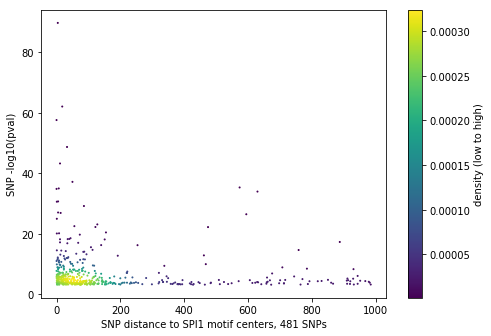

In [14]:
logging.basicConfig(
        format='%(asctime)s %(levelname)-5s %(message)s',
        level=logging.INFO,
        datefmt='%Y-%m-%d %H:%M:%S')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)
snp_dist = [item[0] for item in snp_list if item[1] > 0 and item[0] <= 1000]
snp_pval = [item[1] for item in snp_list if item[1] > 0 and item[0] <= 1000]

x=snp_dist
y=snp_pval
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

print("Of top 10k "+tf+" SNPs with highest p-val, ", len(snp_dist), " SNPs have distance to nearest motif center < 1000")

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.scatter(snp_dist, snp_pval, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("SNP distance to " + tf + " motif centers, " + str(len(snp_dist)) + " SNPs")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    
fig.savefig(tf+"_snp_1k.png", bbox_inches='tight')
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib


Of top 10k SPI1 SNPs with highest p-val,  9092  SNPs have motif in the same Chromosome


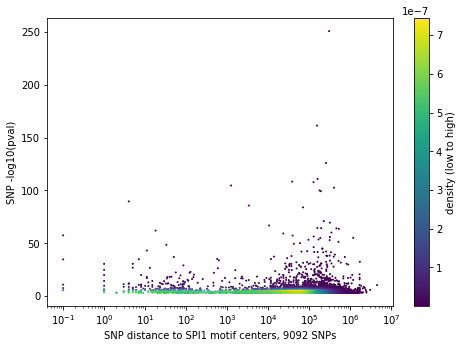

In [13]:
'''

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.stats import gaussian_kde

#fig=plt.figure(figsize=(10, 8), dpi= 100)
snp_dist = [item[0] for item in snp_list if item[1] > 0 and item[0] <= 10000]
snp_pval = [item[1] for item in snp_list if item[1] > 0 and item[0] <= 10000]

x=snp_dist
y=snp_pval
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

print(len(snp_dist))
plt.scatter(snp_dist, snp_pval, 1, c=z, alpha=1, marker='o', label=".")
plt.xlabel("SNP distance to RELA motif centers")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()    

# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
'''
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.stats import gaussian_kde

for item in snp_list:
    if item[0] == 0:
        item[0] = 0.1
#fig=plt.figure(figsize=(10, 8), dpi= 100)
snp_dist = [item[0] for item in snp_list]
snp_pval = [item[1] for item in snp_list]

x=snp_dist
y=snp_pval
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

print("Of top 10k "+tf+" SNPs with highest p-val, ", len(snp_dist), " SNPs have motif in the same Chromosome")
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.scatter(snp_dist, snp_pval, 1, c=z, alpha=1, marker='o', label=".")
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("SNP distance to "+ tf +" motif centers, " + str(len(snp_dist)) + " SNPs")
plt.ylabel("SNP -log10(pval)")
plt.colorbar(label='density (low to high)')

#plt.legend(loc=2)
plt.show()  
fig.savefig(tf+"_snp_log.png", bbox_inches='tight')
